# 📚 Chapter 4: Solubility Deep Dive with Linear Models

*This notebook contains the code examples in chapter 4. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH04_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- Solubility and how to model it with linear regression
- The mechanics of how linear models are trained
- A tour of linear models accessible via Scikit-Learn
- How to evaluate a model’s regression performance and applicability domain
- What causes overfitting and how we mitigate it by analyzing a model’s bias-variance trade-offs

## ⚙️ Part 0: Installation and Setup

**❗️NOTE:** After setting up a local environment, install the required packages via:
`!pip install -r https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/requirements.txt --quiet`

**❗️NOTE:** If running notebook via Colab, be sure to install RDKit via: `!pip install rdkit`

### Import and Setup Packages 

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

In [2]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15

## 1️⃣ Solubility with Linear Regression

### Load the Data

In [3]:
from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split = data.get_split(method = 'scaffold')

Downloading...
100%|██████████| 853k/853k [00:00<00:00, 1.91MiB/s]
Loading...
Done!
100%|██████████| 9982/9982 [00:05<00:00, 1724.45it/s]


In [4]:
train_df, valid_df, test_df = split['train'], split['valid'], split['test']

In [ ]:
train_df.head()

,Drug_ID,Drug,Y
0,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
1,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
2,4-(dimethylamino)benzaldehyde,CN(C)c1ccc(C=O)cc1,-2.282769
3,2-methyl-1-phenylpropan-2-yl acetate,CC(=O)OC(C)(C)Cc1ccccc1,-2.394650
4,5-methoxy-1-[4-(trifluoromethyl)phenyl]pentan-...,COCCCCC(=O)c1ccc(C(F)(F)F)cc1,-3.544060


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  6987 non-null   object 
 1   Drug     6987 non-null   object 
 2   Y        6987 non-null   float64
dtypes: float64(1), object(2)
memory usage: 163.9+ KB


### Target Variable Distribution

**Code for Figure 4.1**

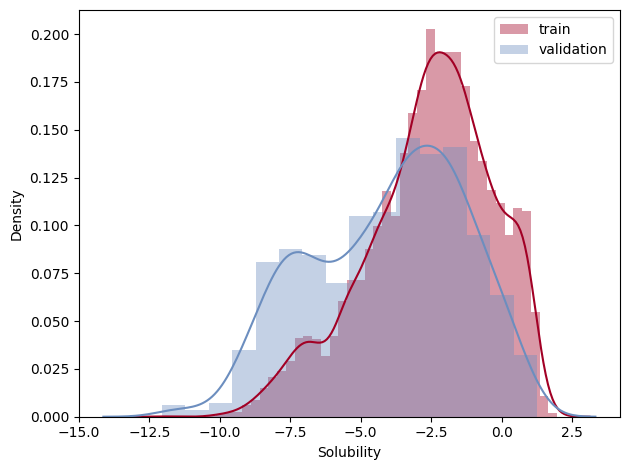

In [ ]:
plt.figure()
sns.distplot(train_df.Y, kde=True, label='train')
sns.distplot(valid_df.Y, kde=True, label='validation')
plt.xlabel('Solubility')
plt.legend()
plt.tight_layout()
plt.savefig('figures/ch04/solubility_dists.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/solubility_dists.pdf', bbox_inches='tight', dpi=600);

**Code for Figure 4.2. Visualize the least soluble moleculse (top row) and the most soluble molecules (bottom row) from the training data**

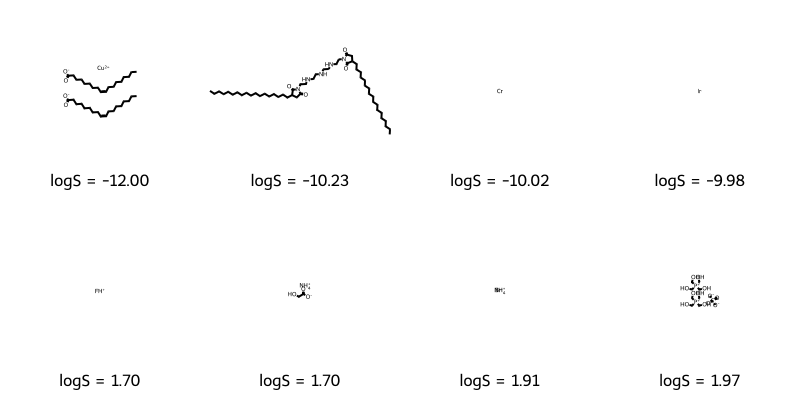

In [8]:
from rdkit import Chem
train_df_sorted = train_df.sort_values("Y")
extremes = pd.concat([train_df_sorted[:4], train_df_sorted[-4:]])
legend_text = [
    f"logS = {x.Y:.2f}" for x in extremes.itertuples()
]
extreme_mols = [Chem.MolFromSmiles(smi) for smi in extremes.Drug]
img = Draw.MolsToGridImage(
    extreme_mols, molsPerRow=4, legends=legend_text, useSVG=True, drawOptions=dopts,
)
with open("figures/ch04/solubility_extremes.svg", "w") as f:
  f.write(img.data)
img

**Code for Figure 4.3. Visualizing training molecules with greatest number of fragments.**

In [5]:
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(train_df, 'Drug', 'Molecule')

In [9]:
train_df['fragment_count'] = train_df.Molecule.apply(lambda x: len(Chem.GetMolFrags(x)))

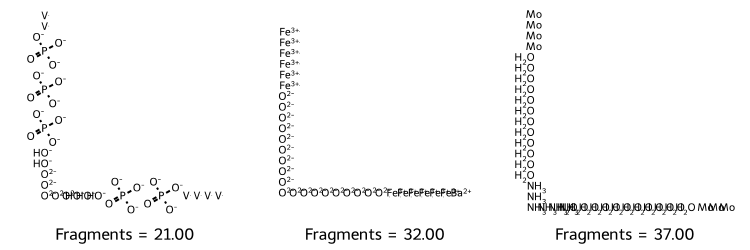

In [ ]:
extremes = train_df.sort_values("fragment_count")[-3:]
legend_text = [
    f"Fragments = {x.fragment_count:.2f}" for x in extremes.itertuples()
]
img = Draw.MolsToGridImage(
    extremes.Molecule, molsPerRow=3, subImgSize=(250, 250), legends=legend_text, useSVG=True, drawOptions=dopts,
)
with open("figures/ch04/fragment_extremes.svg", "w") as f:
  f.write(img.data)
img

In [10]:
train_df = train_df[train_df.fragment_count == 1]
train_df.shape[0]

6139

### Feature Computation & Correlation

**Define features and compute them for the training data**

In [11]:
from rdkit.Chem import (
    Crippen,
    Descriptors,
    GraphDescriptors,
    Lipinski,
    MolFromSmarts,
    rdMolDescriptors,
)

def AromaticProportion(mol):
  aromatic_atoms = mol.GetSubstructMatches(
      MolFromSmarts("a")
  )
  return len(aromatic_atoms) / mol.GetNumAtoms()

RDKIT_DESCRIPTORS = {
  'Molecular Weight' : Descriptors.MolWt,
  'Number of H-Bond Donors' : Descriptors.NumHDonors,
  'TPSA' : Descriptors.TPSA,
  'logP' : Crippen.MolLogP,
  'Molar Refractivity' : Crippen.MolMR,
  'Number of Rotatable Bonds' : Lipinski.NumRotatableBonds,
  'Number of Rings' : rdMolDescriptors.CalcNumRings,
  'LabuteASA' : rdMolDescriptors.CalcLabuteASA,
  'BalabanJ' : GraphDescriptors.BalabanJ,
  'BertzCT' : GraphDescriptors.BertzCT,
  'Aromatic Proportion' : AromaticProportion,
}

for desc, func in RDKIT_DESCRIPTORS.items():
  train_df[desc] = train_df["Molecule"].apply(func)

In [12]:
train_df[train_df.isna().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,fragment_count,Molecular Weight,Number of H-Bond Donors,TPSA,logP,Molar Refractivity,Number of Rotatable Bonds,Number of Rings,LabuteASA,BalabanJ,BertzCT,Aromatic Proportion


**Code for Figure 4.4. Scatterplots of each descriptor with respect to solubility**

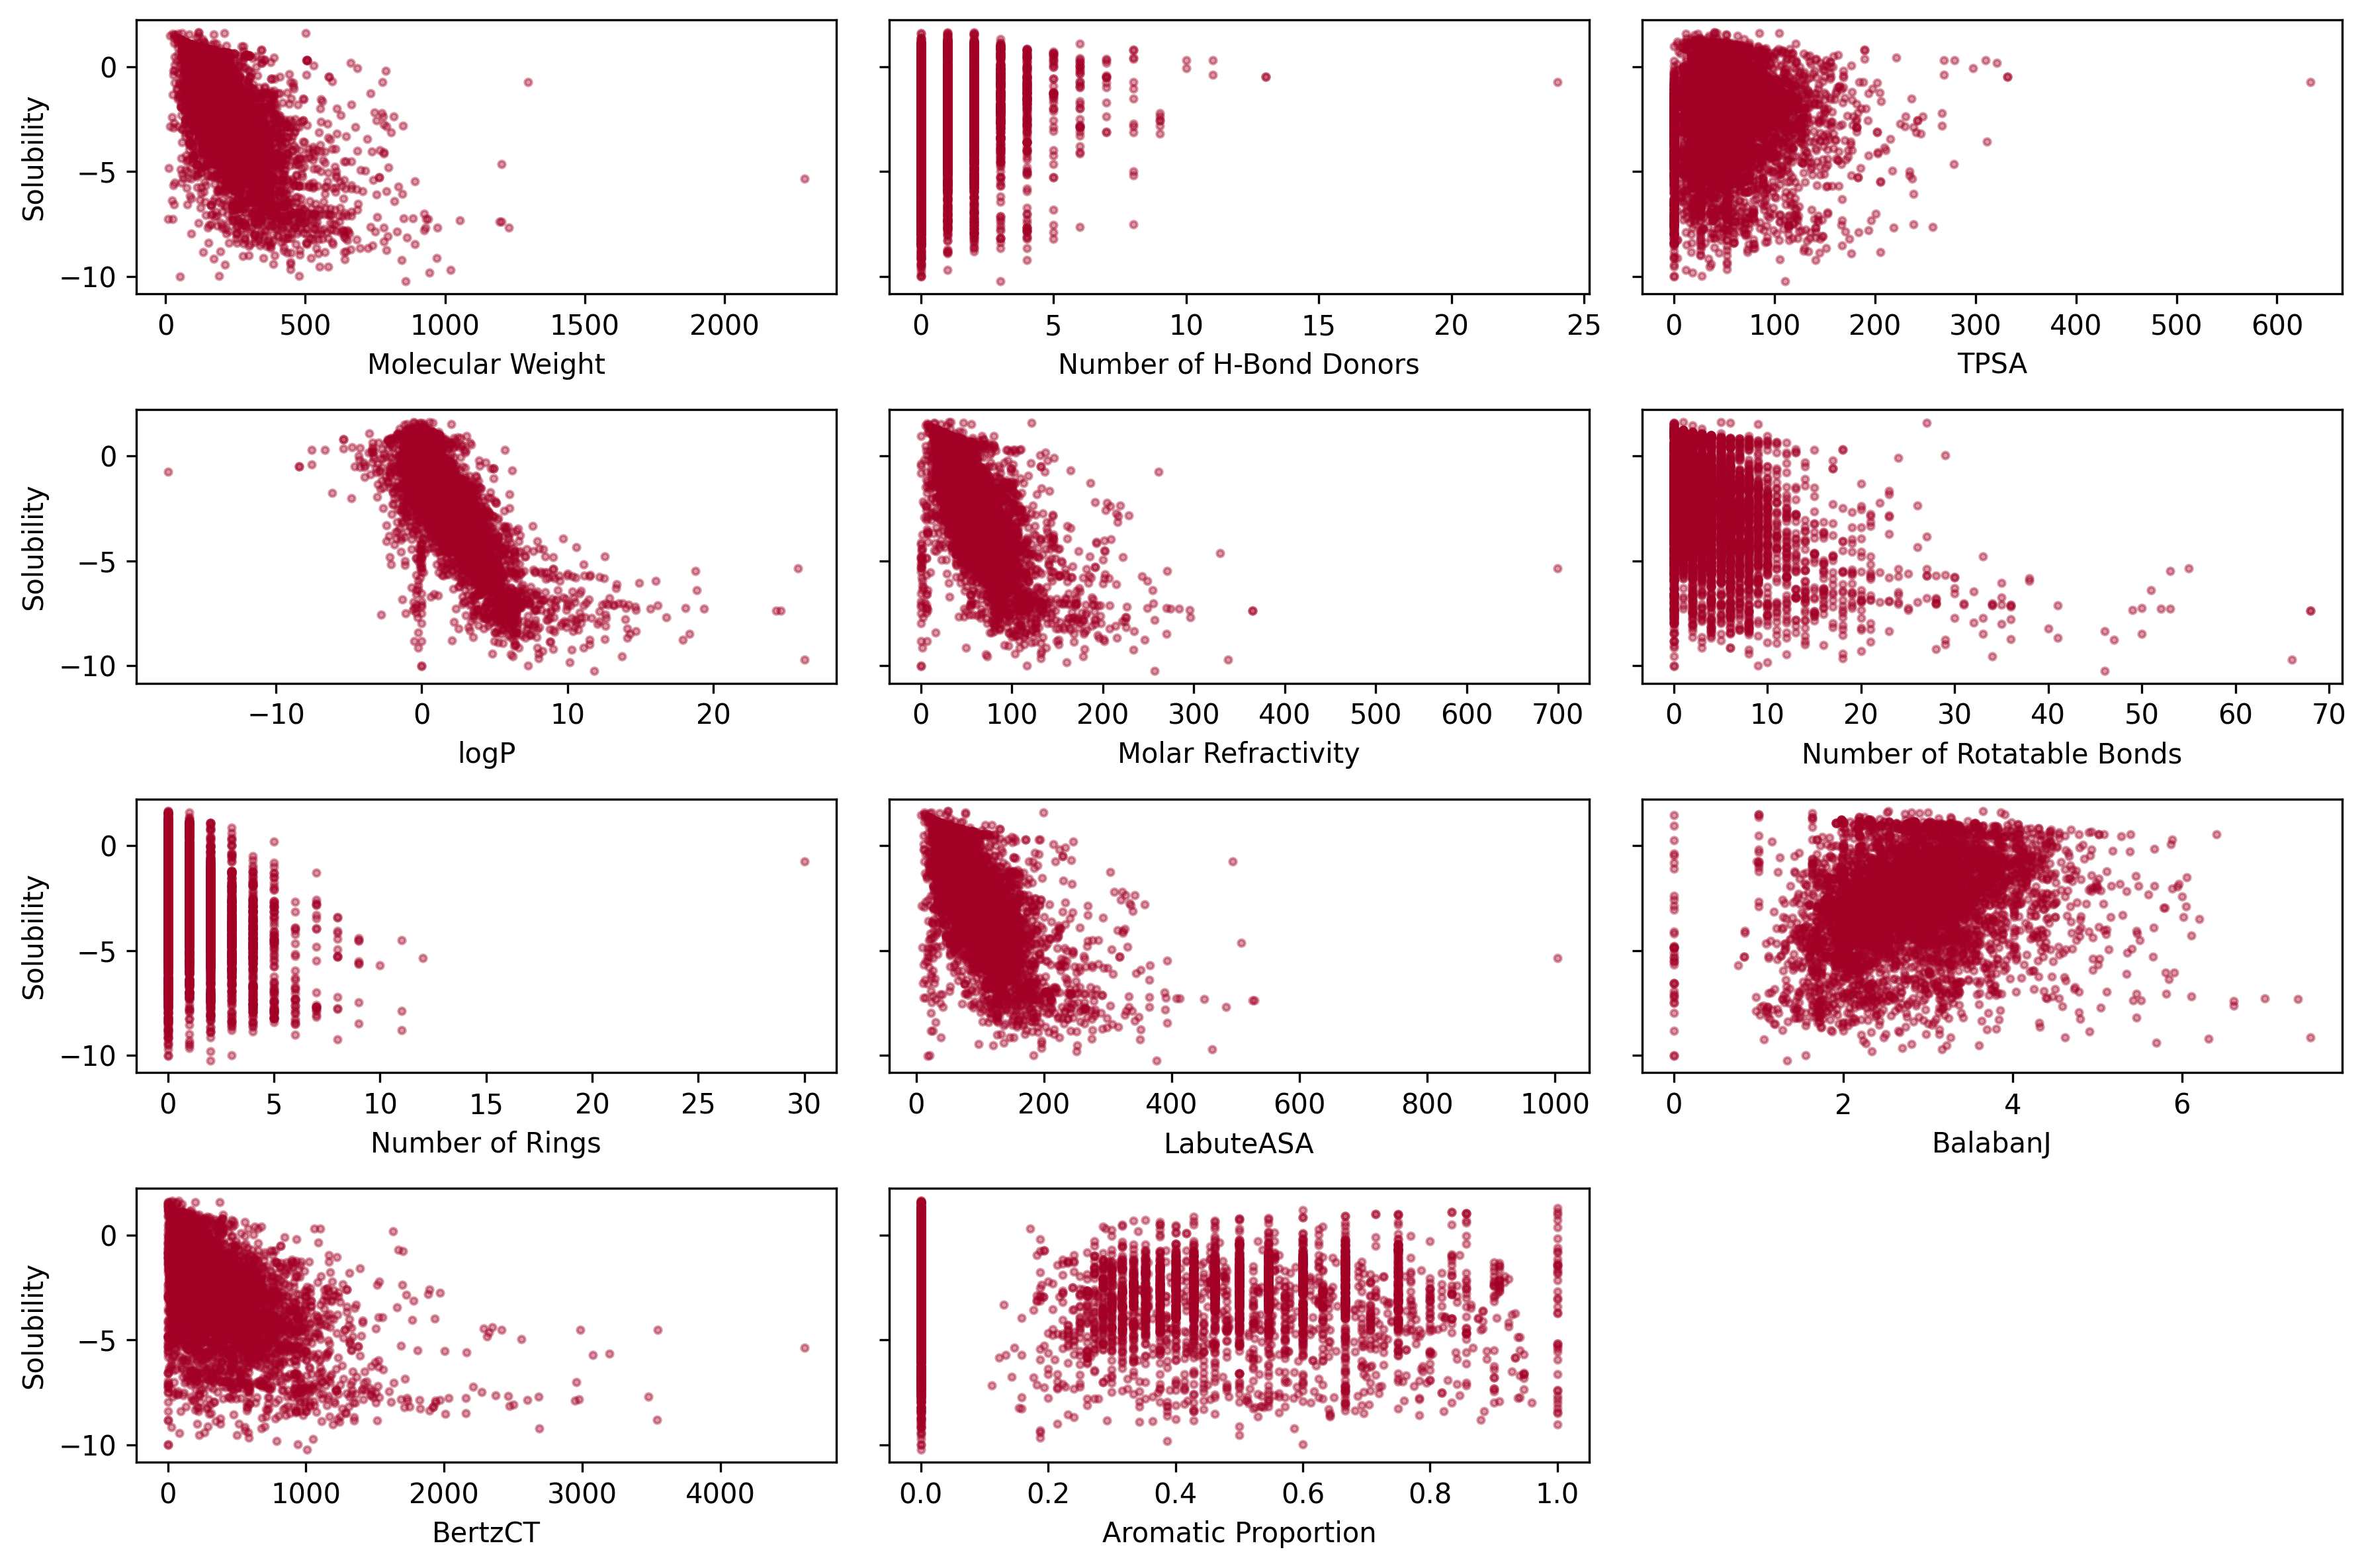

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()
features = train_df.columns[5:]
for i, feature in enumerate(features):
    ax = axs[i]
    ax.scatter(
        train_df[feature], train_df.Y, s=6, alpha=0.4,
    )
    if i % 3 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(feature)
for i in range(len(features), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.savefig('figures/ch04/scatterplot_eda.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/scatterplot_eda.pdf', bbox_inches='tight', dpi=600);

**Code for Figure 4.5. Correlation heatmap for each pair of descriptors and solubility**

In [ ]:
corr_matrix = train_df[features.tolist() + ['Y']].rename(columns={'Y':'Solubility'}).corr()
mask = np.triu(corr_matrix)

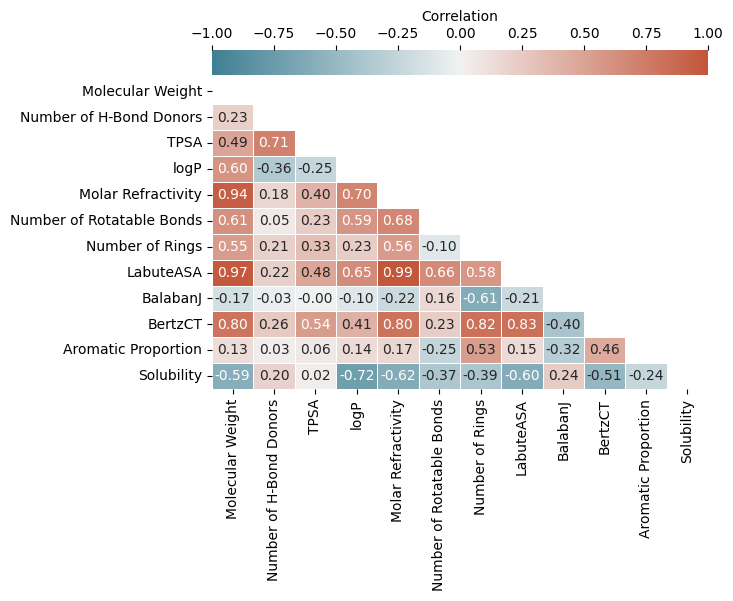

In [ ]:
g = sns.heatmap(
    corr_matrix,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    mask=mask,
    linewidth=.5,
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=1,
    cbar_kws={
        'label': 'Correlation',
        'location': 'top',
        'orientation': 'horizontal',
        'pad': 0.01,
    },
)
#plt.tight_layout()
plt.savefig('figures/ch04/heatmap_eda.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/heatmap_eda.pdf', bbox_inches='tight', dpi=600);

**Simplicity of bounding box method only requires summary statistics to bound the applicability domain by the joint min and max values of each descriptor**

In [ ]:
train_df.describe()

,Y,fragment_count,Molecular Weight,Number of H-Bond Donors,TPSA,logP,Molar Refractivity,Number of Rotatable Bonds,Number of Rings,LabuteASA,BalabanJ,BertzCT,Aromatic Proportion
count,6139.000000,6139.0,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000
mean,-2.687823,1.0,231.519565,1.037465,52.514387,2.221913,60.059111,4.188793,1.137645,93.835955,2.838501,361.566059,0.274302
std,2.177925,0.0,129.110403,1.302389,40.799635,2.395077,35.624349,5.183913,1.399430,53.060495,0.783718,344.678348,0.282455
min,-10.234717,1.0,9.012000,0.000000,0.000000,-17.406400,0.000000,0.000000,0.000000,7.504228,0.000000,0.000000,0.000000
25%,-3.970000,1.0,148.203500,0.000000,25.780000,0.866500,38.219800,1.000000,0.000000,60.327033,2.324238,132.937410,0.000000
50%,-2.446100,1.0,206.245000,1.000000,46.330000,1.947500,52.294300,3.000000,1.000000,82.504603,2.847379,280.893937,0.285714
75%,-1.199550,1.0,282.731000,2.000000,72.830000,3.222950,74.464050,5.000000,2.000000,115.451785,3.257586,476.949898,0.500000
max,1.630235,1.0,2285.676000,24.000000,633.200000,26.246600,699.523400,68.000000,30.000000,1003.761596,7.517310,4609.941412,1.000000


### Linear Regression

**Code for Figure 4.8. Train and visualize a simple linear regressor**

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
X_train, y_train = train_df[['logP']], train_df.Y
lin_reg.fit(X_train, y_train)
y_train_preds = lin_reg.predict(X_train)

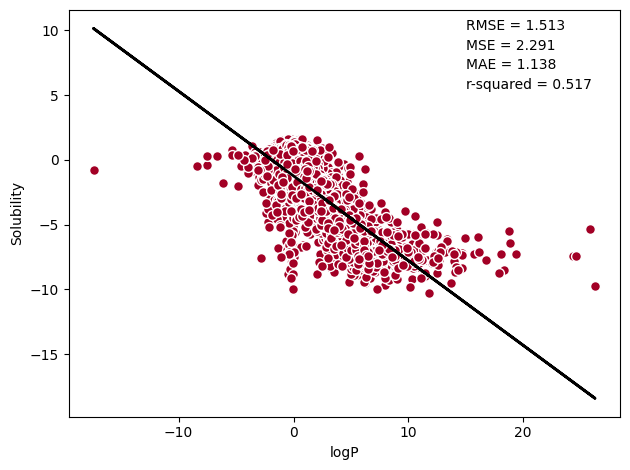

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.scatter(X_train, y_train, edgecolor='white', s=50)
plt.plot(X_train, y_train_preds, color='black', lw=2)
plt.xlabel('logP')
plt.ylabel('Solubility')
plt.annotate("RMSE = {:.4}".format(np.sqrt(mean_squared_error(y_train, y_train_preds))), (15, 10))
plt.annotate("MSE = {:.4}".format(mean_squared_error(y_train, y_train_preds)), (15, 8.5))
plt.annotate("MAE = {:.4}".format(mean_absolute_error(y_train, y_train_preds)), (15, 7))
plt.annotate("r-squared = {:.4}".format(r2_score(y_train, y_train_preds)), (15, 5.5))
plt.tight_layout()
plt.savefig('figures/ch04/simple_linear_regression.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/simple_linear_regression.pdf', bbox_inches='tight', dpi=600);

## 2️⃣ The Learning Algorithm

*Companion code does not accompany this section of the book.*

## 3️⃣ Touring Scikit-Learn Linear Models

### Defining a Benchmark

In [14]:
from sklearn.preprocessing import StandardScaler

PandasTools.AddMoleculeColumnToFrame(valid_df, 'Drug', 'Molecule')
valid_df['fragment_count'] = valid_df.Molecule.apply(lambda x: len(Chem.GetMolFrags(x)))
valid_df = valid_df[valid_df.fragment_count == 1]
for desc, func in RDKIT_DESCRIPTORS.items():
  valid_df[desc] = valid_df["Molecule"].apply(func)
X_val = valid_df[['logP']]

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_val = scaler.transform(X_val)

In [20]:
esol_df = pd.read_csv("data/delaney_solubility.txt", sep=',')
PandasTools.AddMoleculeColumnToFrame(esol_df, 'SMILES', 'Molecule')

valid_df['Inchi'] = valid_df.Molecule.apply(Chem.MolToInchiKey)
esol_df['Inchi'] = esol_df.Molecule.apply(Chem.MolToInchiKey)

valid_df_exclude_esol = pd.merge(valid_df, esol_df, how="outer", on="Inchi", indicator=True)
valid_df_exclude_esol = valid_df_exclude_esol.loc[valid_df_exclude_esol._merge == "left_only"]

esol_val_pred_original = 0.16 - 0.63 * valid_df_exclude_esol.logP - 0.0062 * valid_df_exclude_esol["Molecular Weight"] + 0.066 * valid_df_exclude_esol["Number of Rotatable Bonds"] - 0.74 * valid_df_exclude_esol["Aromatic Proportion"]

esol_val_pred_refit = 0.26 - 0.74 * valid_df_exclude_esol.logP - 0.0034 * valid_df_exclude_esol["Molecular Weight"] + 0.034 * valid_df_exclude_esol["Number of Rotatable Bonds"] - 0.42 * valid_df_exclude_esol["Aromatic Proportion"]

print(f"RMSE with original ESOL coefficients: {np.sqrt(mean_squared_error(valid_df_exclude_esol.Y, esol_val_pred_original)):.4f}")
print(f"RMSE with refitted ESOL coefficients: {np.sqrt(mean_squared_error(valid_df_exclude_esol.Y, esol_val_pred_refit)):.4f}")

RMSE with original ESOL coefficients: 1.4579
RMSE with refitted ESOL coefficients: 1.7720


### Ridge Regression & Feature Selection

In [ ]:
from scipy.stats import uniform as sp_rand
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train, y_train = train_df[features.tolist()], train_df.Y
X_val, y_val = valid_df[features.tolist()], valid_df.Y

param_dist = {
    'ridge__alpha' : sp_rand(),
}

pipe = Pipeline([
  ('imputer', SimpleImputer(strategy="median")),
  ('standardscaler', StandardScaler(with_mean=True, with_std=True)),
  ('ridge', Ridge()),
])

rs_estimator = RandomizedSearchCV(
  estimator=pipe,
  param_distributions=param_dist,
  scoring="neg_mean_squared_error",
  cv=5,
  n_iter=20,
)

rs_estimator.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge())]),
                   n_iter=20,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0bdf737d00>},
                   scoring='neg_mean_squared_error')

In [ ]:
best_ridge_estimator = rs_estimator.best_estimator_
y_train_preds = best_ridge_estimator.predict(X_train)
y_val_preds = best_ridge_estimator.predict(X_val)

In [ ]:
rs_estimator.best_params_

{'ridge__alpha': 0.9699098521619943}

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_preds))

print(f"Train RMSE: {train_rmse:.4f}\nValidation RMSE: {val_rmse:.4f}")

Train RMSE: 1.3687
Validation RMSE: 1.4890


**Code for Figure 4.15. Ridge regression coefficients as a proxy for feature importance**

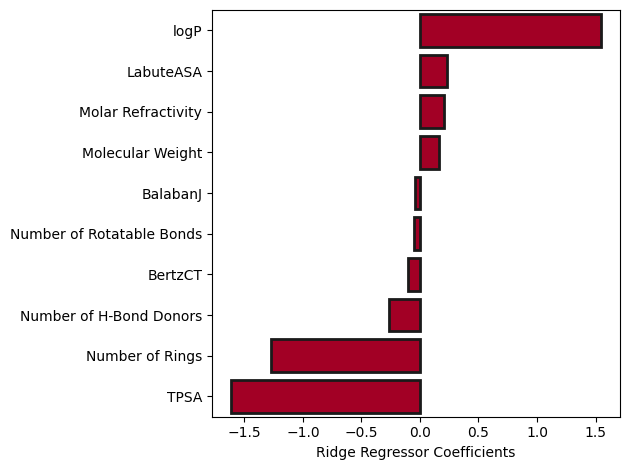

In [ ]:
sorted_coefficients, sorted_features = zip(*sorted(zip(best_ridge_estimator.named_steps['ridge'].coef_[1:,], features.tolist()), reverse=True))
sns.barplot(x=list(sorted_coefficients), y=list(sorted_features), linewidth=2, edgecolor=".1", facecolor=colors[0])

plt.xlabel('Ridge Regressor Coefficients')
plt.tight_layout()
plt.savefig('figures/ch04/ridge_regressor_features.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/ridge_regressor_features.pdf', bbox_inches='tight', dpi=600);

### Robust Estimation with RANSAC

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

forward_feature_selector = SequentialFeatureSelector(
  RidgeCV(alphas=np.logspace(-4, 1, num=10)),
  n_features_to_select="auto",
  tol=1e-3,
  direction="forward",
  scoring="neg_mean_squared_error"
)

model = make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), forward_feature_selector, RidgeCV(alphas=np.logspace(-4, 1, num=10)))
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=RidgeCV(alphas=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01])),
                                           scoring='neg_mean_squared_error',
                                           tol=0.001)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01])))])

In [ ]:
model[3].alpha_

0.7742636826811278

In [ ]:
print(f"Features selected: {features[model[2].get_support()]}")

Features selected: Index(['Molecular Weight', 'logP', 'Molar Refractivity',
       'Number of Rotatable Bonds', 'LabuteASA', 'BalabanJ', 'BertzCT'],
      dtype='object')


In [ ]:
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_preds))

print(f"Train RMSE: {train_rmse:.4f}\nValidation RMSE: {val_rmse:.4f}")

Train RMSE: 1.3757
Validation RMSE: 1.4966


In [ ]:
engineered_features = features[model[2].get_support()]
X_train, y_train = train_df[engineered_features], train_df.Y
X_val, y_val = valid_df[engineered_features], valid_df.Y

In [ ]:
from sklearn.linear_model import RANSACRegressor

ransac_regressor = Pipeline([
  ('imputer', SimpleImputer(strategy="median")),
  ('standardscaler', StandardScaler()),
  ('ransac', RANSACRegressor(estimator=LinearRegression(), max_trials=200, min_samples=0.95, random_state=RANDOM_SEED)),
])

ransac_regressor.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('ransac',
                 RANSACRegressor(estimator=LinearRegression(), max_trials=200,
                                 min_samples=0.95, random_state=42))])

In [ ]:
y_train_preds = ransac_regressor.predict(X_train)
y_val_preds = ransac_regressor.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_preds))

print(f"Train RMSE: {train_rmse:.4f}\nValidation RMSE: {val_rmse:.4f}")

Train RMSE: 1.3963
Validation RMSE: 1.4554


In [ ]:
ransac_regressor.named_steps["ransac"].estimator_

LinearRegression()

In [ ]:
sorted(zip(ransac_regressor.named_steps["ransac"].estimator_.coef_, engineered_features.tolist()), reverse=True)

[(1.4245773928981378, 'Molar Refractivity'),
 (0.230334407292345, 'Number of Rotatable Bonds'),
 (0.10754758522779101, 'BalabanJ'),
 (-0.4014272804660504, 'BertzCT'),
 (-0.45354996226548133, 'Molecular Weight'),
 (-1.2463115431898368, 'LabuteASA'),
 (-1.6083518896977724, 'logP')]

### Support Vector Regression

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svr__loss' : ['squared_error', 'huber', 'epsilon_insensitive'],
    'svr__alpha' : np.logspace(-6, 2, num=9),
    'svr__learning_rate' : ['invscaling', 'adaptive'],
    'svr__early_stopping' : [True, False],
    'svr__penalty' : ['l2', None],
    'polynomialfeatures__degree' : [1, 2],
}

pipe = Pipeline([
  ('imputer', SimpleImputer(strategy="median")),
  ('polynomialfeatures', PolynomialFeatures()),
  ('standardscaler', StandardScaler()),
  ('svr', SGDRegressor(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED)),
])

rs_estimator = GridSearchCV(
  estimator=pipe,
  param_grid=param_grid,
  scoring="neg_mean_squared_error",
  cv=5,
)

rs_estimator.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('svr', SGDRegressor(random_state=42))]),
             param_grid={'polynomialfeatures__degree': [1, 2],
                         'svr__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02]),
                         'svr__early_stopping': [True, False],
                         'svr__learning_rate': ['invscaling', 'adaptive'],
                         'svr__loss': ['squared_error', 'huber',
                                       'epsilon_insensitive'],
                         'svr__penalty': ['l2', None]},
             scoring='neg_mean_squared_error')

In [ ]:
best_svr_estimator = rs_estimator.best_estimator_
y_train_preds = best_svr_estimator.predict(X_train)
y_val_preds = best_svr_estimator.predict(X_val)

In [ ]:
rs_estimator.best_params_

{'polynomialfeatures__degree': 2,
 'svr__alpha': 0.1,
 'svr__early_stopping': True,
 'svr__learning_rate': 'invscaling',
 'svr__loss': 'epsilon_insensitive',
 'svr__penalty': 'l2'}

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_preds))

print(f"Train RMSE: {train_rmse:.4f}\nValidation RMSE: {val_rmse:.4f}")

Train RMSE: 1.3359
Validation RMSE: 1.3791


**Code for Figure 4.17. Connection to Stochastic Gradient Descent**

In [ ]:
sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

epochs = range(1, 30)
train_losses, train_losses_constant_lr = [], []
val_losses, val_losses_constant_lr = [], []

def epsilon_insensitive_loss(y_true, y_pred, epsilon=0.1):
    # Calculate absolute differences between predicted and actual values
    absolute_diff = np.abs(y_true - y_pred)

    # Compute the loss with epsilon-insensitive margin
    loss = np.maximum(0, absolute_diff - epsilon)

    return np.mean(loss)

for epoch in epochs:
  sgd_regressor.set_params(sgdregressor__max_iter=epoch, sgdregressor__early_stopping=False)
  sgd_regressor.fit(X_train, y_train)
  y_train_preds = sgd_regressor.predict(X_train)
  y_val_preds = sgd_regressor.predict(X_val)
  train_losses.append(epsilon_insensitive_loss(y_train, y_train_preds))
  val_losses.append(epsilon_insensitive_loss(y_val, y_val_preds))

  sgd_regressor.set_params(sgdregressor__max_iter=epoch, sgdregressor__early_stopping=False, sgdregressor__learning_rate='constant')
  sgd_regressor.fit(X_train, y_train)
  y_train_preds = sgd_regressor.predict(X_train)
  y_val_preds = sgd_regressor.predict(X_val)
  train_losses_constant_lr.append(epsilon_insensitive_loss(y_train, y_train_preds))
  val_losses_constant_lr.append(epsilon_insensitive_loss(y_val, y_val_preds))

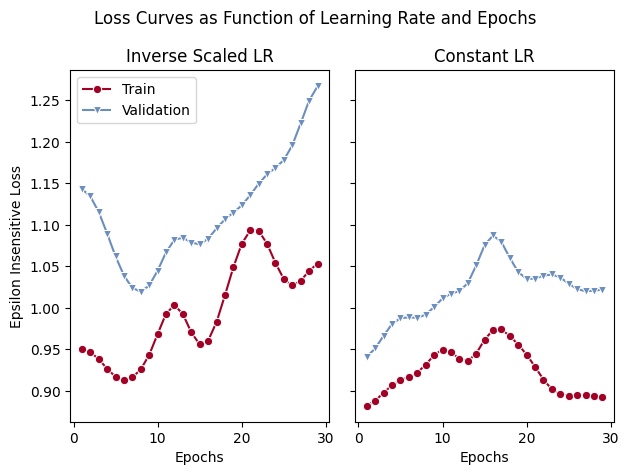

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

fig, axes =plt.subplots(1, 2, sharey=True)
fig.suptitle("Loss Curves as Function of Learning Rate and Epochs")

sns.lineplot(ax=axes[0], x=epochs, y=gaussian_filter1d(train_losses, sigma=2), marker="o", label="Train")
sns.lineplot(ax=axes[0], x=epochs, y=gaussian_filter1d(val_losses, sigma=2), marker="v", label="Validation")
axes[0].set_title("Inverse Scaled LR")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Epsilon Insensitive Loss")

sns.lineplot(ax=axes[1], x=epochs, y=gaussian_filter1d(train_losses_constant_lr, sigma=2), marker="o")
sns.lineplot(ax=axes[1], x=epochs, y=gaussian_filter1d(val_losses_constant_lr, sigma=2), marker="v")
axes[1].set_title("Constant LR")
axes[1].set_xlabel("Epochs")

fig.tight_layout()
axes[0].legend(handles=axes[0].get_legend_handles_labels()[0], labels=["Train", "Validation"])
plt.savefig("figures/ch04/sgd_loss_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/sgd_loss_curves.png", bbox_inches='tight', dpi=600)

**Evaluation of final, best performing model on test data and against ESOL and y-scrambled baselines**

In [ ]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

sgd_regressor.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.1, early_stopping=True,
                              loss='epsilon_insensitive'))])

In [ ]:
PandasTools.AddMoleculeColumnToFrame(test_df, 'Drug', 'Molecule')
test_df['fragment_count'] = test_df.Molecule.apply(lambda x: len(Chem.GetMolFrags(x)))
test_df = test_df[test_df.fragment_count == 1]
for desc, func in RDKIT_DESCRIPTORS.items():
  test_df[desc] = test_df["Molecule"].apply(func)

In [ ]:
X_test, y_test = test_df[engineered_features], test_df.Y

y_test_preds = sgd_regressor.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f"SGD Regressor (SVR) Test RMSE: {test_rmse:.4f}")

Test RMSE: 1.2783


In [ ]:
esol_test_pred_original = 0.16 - 0.63 * test_df.logP - 0.0062 * test_df["Molecular Weight"] + 0.066 * test_df["Number of Rotatable Bonds"] - 0.74 * test_df["Aromatic Proportion"]

print(f"RMSE with original ESOL coefficients: {np.sqrt(mean_squared_error(test_df.Y, esol_test_pred_original)):.4f}")

RMSE with original ESOL coefficients: 1.3787


In [ ]:
from tqdm.notebook import trange

y_scrambled_rmse = []
num_iterations = 100
for i in trange(num_iterations):
  y_scrambled = y.sample(frac=1, random_state=None).reset_index(drop=True)
  sgd_regressor.fit(X, y_scrambled)
  y_pred = sgd_regressor.predict(X_test)
  y_scrambled_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

average_rmse = sum(y_scrambled_rmse) / num_iterations
print(f'Average RMSE over {num_iterations} y-scrambled iterations: {average_rmse}')

  0%|          | 0/100 [00:00<?, ?it/s]

Average MSE over 100 y-scrambled iterations: 2.458548361070306


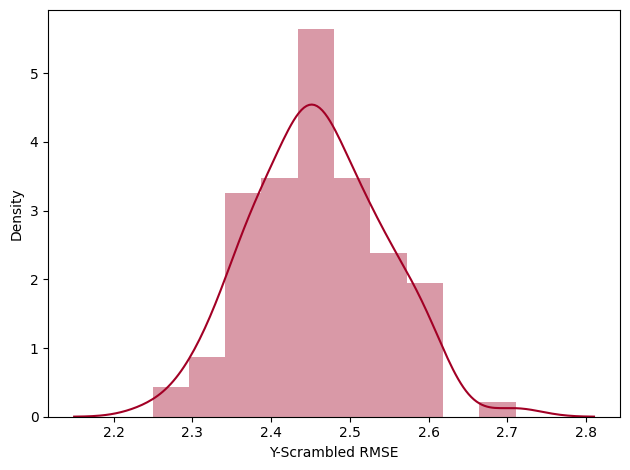

In [ ]:
plt.figure()
sns.distplot(y_scrambled_rmse, kde=True)
plt.xlabel('Y-Scrambled RMSE')
plt.tight_layout()
plt.savefig('figures/ch04/y_scrambled_dist.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch04/y_scrambled_dist.pdf', bbox_inches='tight', dpi=600);

## 4️⃣ Bias-Variance Decomposition

### A Case Study in Polynomials

**Code for Figure 4.18. Impact of model complexity on the fitted model's training and testing performance**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline

In [ ]:
f = lambda i: -0.5 * i ** 7 - 0.3 * i ** 3 + 1.2 * i ** 2 + 0.2 * i - 1
rng = np.random.RandomState(RANDOM_SEED)
X_target = np.linspace(-1, 1, 30)
y_target = f(X_target)

y_sample = y_target + .2 * rng.normal(size=30)

X_train, X_test, y_train, y_test = train_test_split(
    X_target, y_sample, test_size=0.3, random_state=RANDOM_SEED,
)

In [ ]:
polynomial_fit_2 = make_pipeline(
  PolynomialFeatures(degree=2),
  LinearRegression(),
).fit(X_train.reshape(-1, 1), y_train)

polynomial_fit_20 = make_pipeline(
  PolynomialFeatures(degree=20),
  LinearRegression(),
).fit(X_train.reshape(-1, 1), y_train)

In [ ]:
order_train = X_train.argsort()
order_test = X_test.argsort()

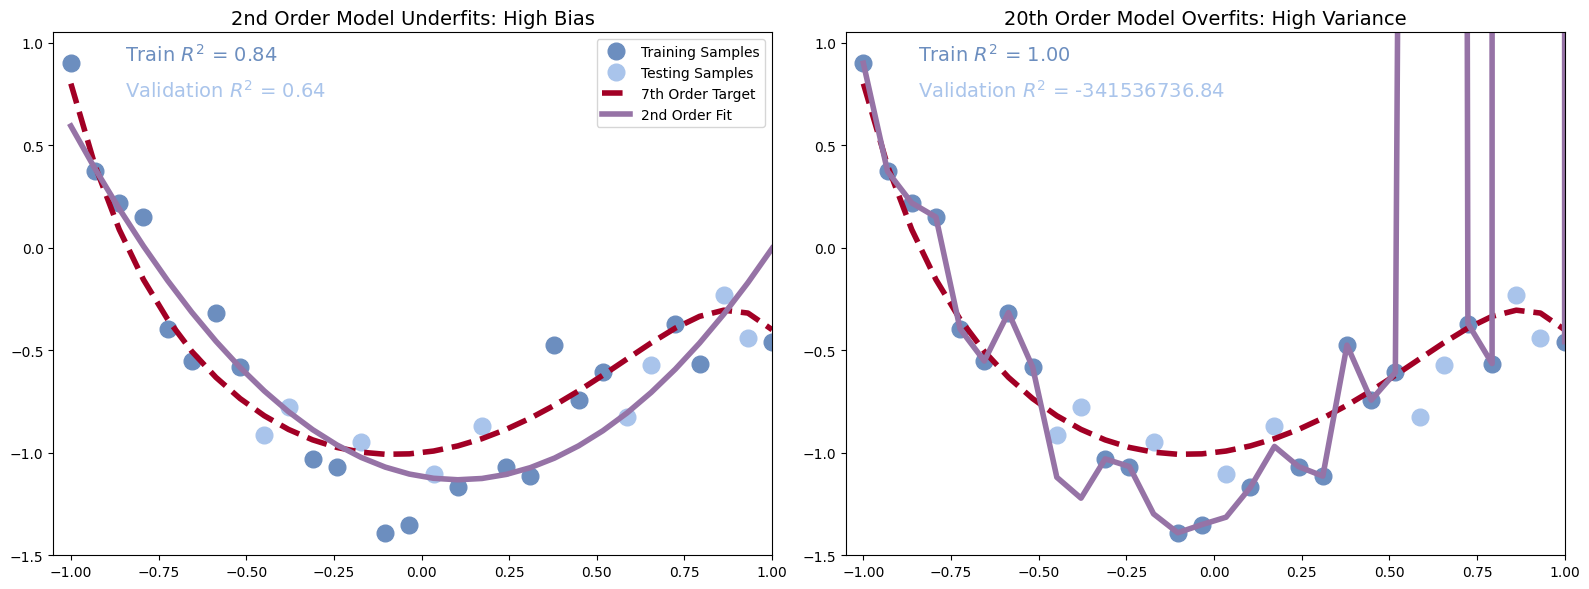

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].plot(X_train[order_train], y_train[order_train], "o", color='#6C8EBF', label="Training Samples", markersize=12)
ax[0].plot(X_test[order_test], y_test[order_test], "o", color='#A9C4EB', label="Testing Samples", markersize=12)
ax[0].text(0.1, 0.98, "Train $R^2$ = {0:.2f}".format(polynomial_fit_2.score(X_train.reshape(-1, 1), y_train)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='#6C8EBF')
ax[0].text(0.1, 0.91, "Validation $R^2$ = {0:.2f}".format(polynomial_fit_2.score(X_test.reshape(-1, 1), y_test)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='#A9C4EB')

ax[0].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[0].plot(X_target, polynomial_fit_2.predict(X_target.reshape(-1, 1)), label="2nd Order Fit", color="#9673A6", linewidth=4)
ax[0].legend(loc="upper right")
ax[0].axis([-1.05, 1.0, -1.5, 1.05])
ax[0].set_title("2nd Order Model Underfits: High Bias", size=14)

ax[1].plot(X_train[order_train], y_train[order_train], "o", color='#6C8EBF', label="Training Samples", markersize=12)
ax[1].plot(X_test[order_test], y_test[order_test], "o", color='#A9C4EB', label="Testing Samples", markersize=12)
ax[1].text(0.1, 0.98, "Train $R^2$ = {0:.2f}".format(polynomial_fit_20.score(X_train.reshape(-1, 1), y_train)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='#6C8EBF')
ax[1].text(0.1, 0.91, "Validation $R^2$ = {0:.2f}".format(polynomial_fit_20.score(X_test.reshape(-1, 1), y_test)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='#A9C4EB')

ax[1].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[1].plot(X_target, polynomial_fit_20.predict(X_target.reshape(-1, 1)), label="10th Order Fit", color="#9673A6", linewidth=4)

ax[1].axis([-1.05, 1.0, -1.5, 1.05])
ax[1].set_title("20th Order Model Overfits: High Variance", size=14)

fig.tight_layout()
fig.savefig('figures/ch04/bias_variance_tradeoff.png', bbox_inches='tight', dpi=600)
fig.savefig('figures/ch04/bias_variance_tradeoff.pdf', bbox_inches='tight', dpi=600);

**Code for Figure 4.19. Impact of high bias or high variance on model's sensitivity to trianing data**

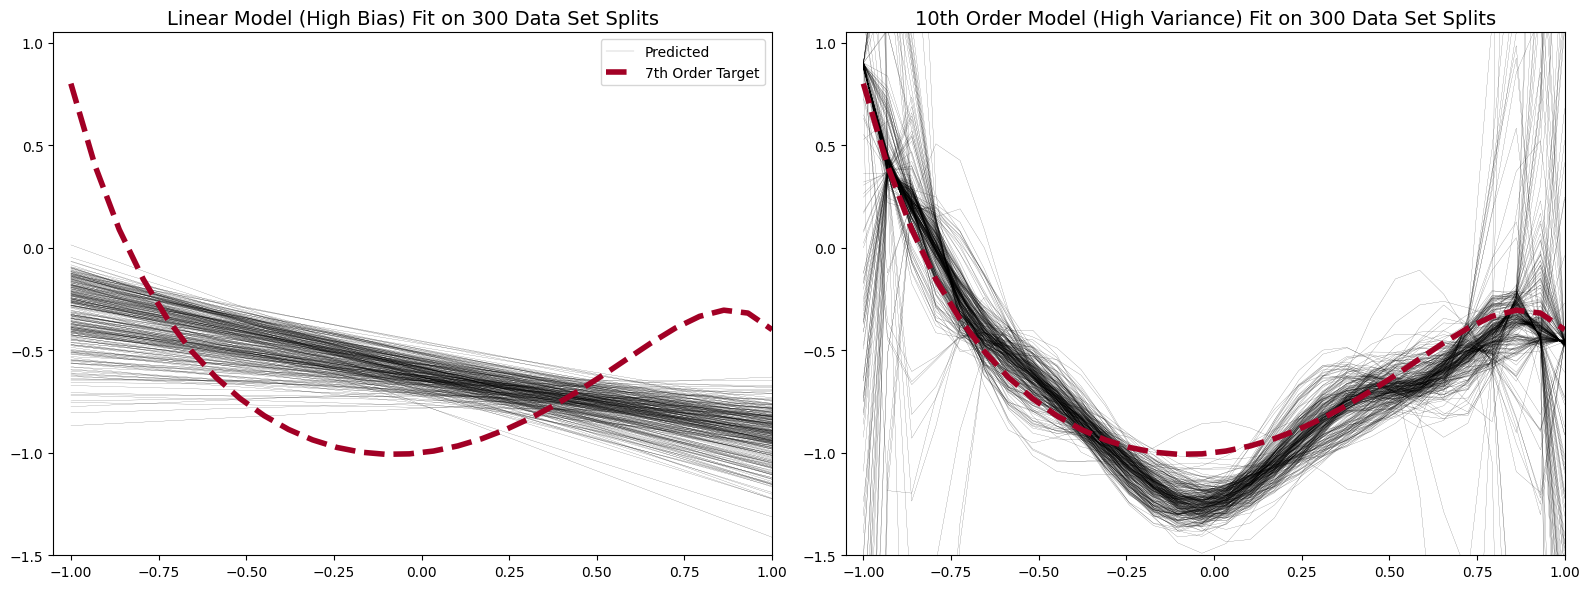

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i in range(300):
  X_train, X_test, y_train, y_test = train_test_split(
      X_target, y_sample, test_size=0.3, random_state=i,
  )

  linear_fit = make_pipeline(
    LinearRegression(),
  ).fit(X_train.reshape(-1, 1), y_train)

  polynomial_fit_10 = make_pipeline(
    PolynomialFeatures(degree=10),
    LinearRegression(),
  ).fit(X_train.reshape(-1, 1), y_train)

  if i == 0:
    ax[0].plot(X_target, linear_fit.predict(X_target.reshape(-1, 1)), label="Predicted", color="black", linewidth=0.1)
    ax[1].plot(X_target, polynomial_fit_10.predict(X_target.reshape(-1, 1)), label="Predicted", color="black", linewidth=0.1)
  else:
    ax[0].plot(X_target, linear_fit.predict(X_target.reshape(-1, 1)), color="black", linewidth=0.1)
    ax[1].plot(X_target, polynomial_fit_10.predict(X_target.reshape(-1, 1)), color="black", linewidth=0.1)

ax[0].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[1].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[0].legend(loc="upper right")

ax[0].axis([-1.05, 1.0, -1.5, 1.05])
ax[1].axis([-1.05, 1.0, -1.5, 1.05])

ax[0].set_title("Linear Model (High Bias) Fit on 300 Data Set Splits", size=14)
ax[1].set_title("10th Order Model (High Variance) Fit on 300 Data Set Splits", size=14)

fig.tight_layout()
fig.savefig('figures/ch04/bias_variance_definition.png', bbox_inches='tight', dpi=600)
fig.savefig('figures/ch04/bias_variance_definition.pdf', bbox_inches='tight', dpi=600);

### Validation Curves & Learning Curves

**Code for Figure 4.21. Validation curves of several SGDRegressor hyperparameters**

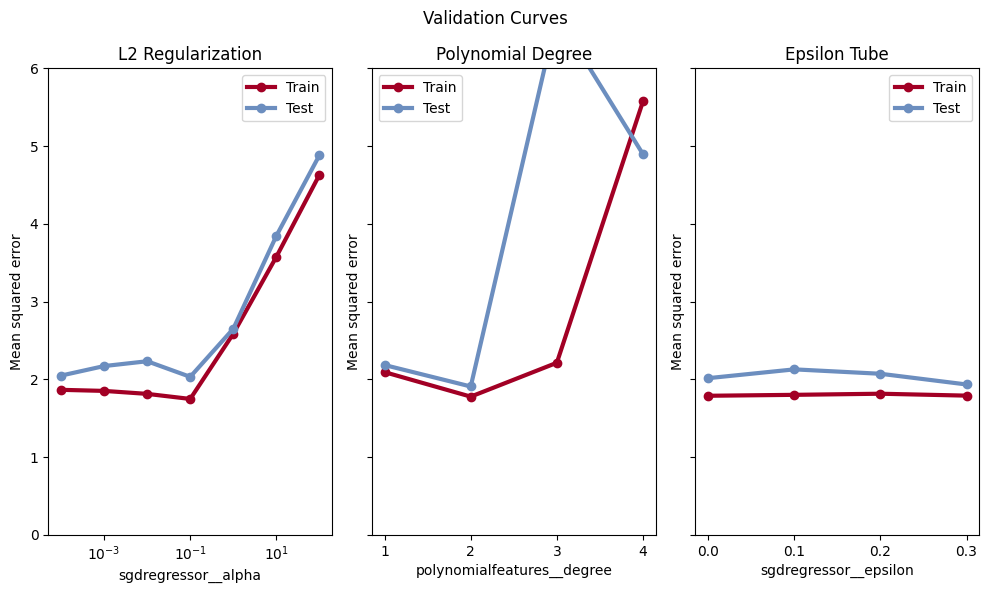

In [ ]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, ValidationCurveDisplay

sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)
fig.suptitle("Validation Curves")
ax[0].set_ylim(top=6)
common_params = {"estimator": sgd_regressor, "X": X_train, "y": y_train, "scoring": "neg_mean_squared_error", "std_display_style": None, "line_kw": {"marker": "o", "lw": 3}, "negate_score": True}

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='sgdregressor__alpha', param_range=np.logspace(-4, 2, num=7), ax=ax[0],
)
handles, label = ax[0].get_legend_handles_labels()
#ax[0].legend(handles[:2], ["Training Score", "Validation Score"])
ax[0].set_title(f"L2 Regularization")

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='polynomialfeatures__degree', param_range=np.arange(1, 5), ax=ax[1],
)
#ax[1].legend(handles[:2], ["Training Score", "Validation Score"])
ax[1].set_title(f"Polynomial Degree")

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='sgdregressor__epsilon', param_range=[0, 0.1, 0.2, 0.3], ax=ax[2],
)
#ax[2].legend(handles[:2], ["Training Score", "Validation Score"])
ax[2].set_title(f"Epsilon Tube")
fig.tight_layout()
plt.savefig("figures/ch04/sgd_validation_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/sgd_validation_curves.png", bbox_inches='tight', dpi=600)

**Code for Figure 4.20. Learning curves of RANSACRegressor vs SGDRegressor (SVR variant)**

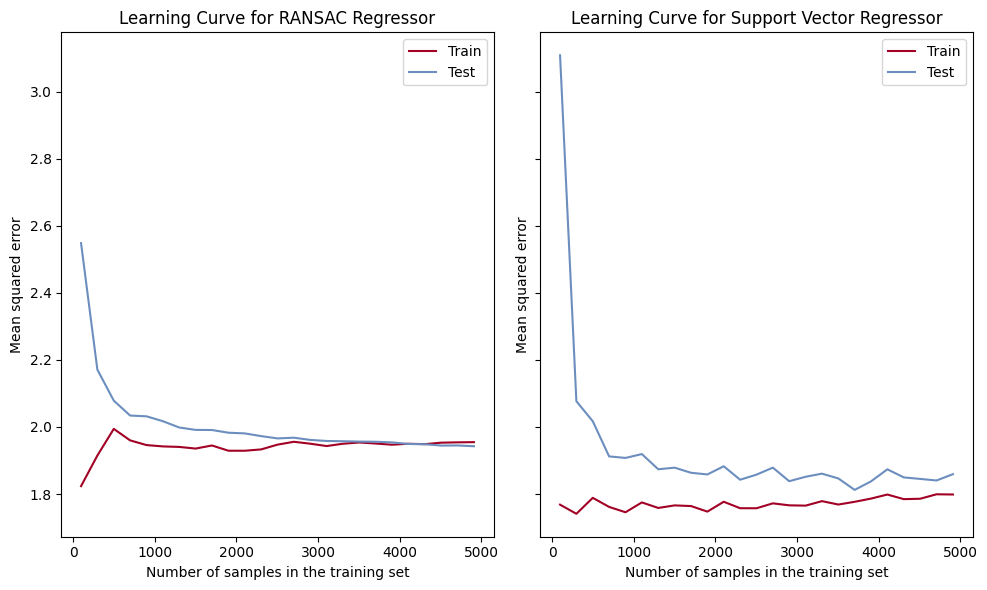

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.02, 1.0, 50),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "scoring": "neg_mean_squared_error",
    "score_type": "both",
    "std_display_style": None,
    "negate_score": True
}

estimator_names = {0 : 'RANSAC Regressor', 1 : 'Support Vector Regressor'}

for ax_idx, estimator in enumerate([ransac_regressor, sgd_regressor]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Train", "Test"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator_names[ax_idx]}")

fig.tight_layout()
plt.savefig("figures/ch04/learning_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/learning_curves.png", bbox_inches='tight', dpi=600)